In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')  #/content/gdrive/MyDrive/DL_cousework2/hamiltonianNNetODEs-master/HHsystem/HamiltonianNet_HenonHeiles.py

# !python file.py

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [179]:
%cd /content/gdrive/MyDrive/Colab Notebooks/NLoscillator

/content/gdrive/MyDrive/Colab Notebooks/NLoscillator


In [180]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jul  4 18:56:15 2020
@author: marios
This file contains all the functions used for numerical integrators
"""

import numpy as np
from scipy.integrate import odeint



###################
# Symplectic Euler
####################
def symEuler(Ns, x0,px0,t0, t_max, lam=1):
    t_s = np.linspace(t0, t_max, Ns+1)
    x_s = np.zeros(Ns+1); p_s = np.zeros(Ns+1)
    x_s[0], p_s[0] = x0, px0
    dts = t_max/Ns; 

    for n in range(Ns):
        x_s[n+1] = x_s[n] + dts*p_s[n]
        p_s[n+1] = p_s[n] - dts*(x_s[n+1] + lam*x_s[n+1]**3)

    E_euler = energy(x_s, p_s, lam=1)
    return E_euler, x_s, p_s, t_s


# Energy of nonlinear oscillator
def energy(x, px, lam=1):    
    Nx=len(x); 
    x=x.reshape(Nx);        px=px.reshape(Nx);    
    E = 0.5*px**2 + 0.5*x**2 + lam*x**4/4
    E = E.reshape(Nx)
    return E



#####################################
# Scipy Solver   
######################################
def f(u, t ,lam=1):
    x,  px = u      # unpack current values of u
    derivs = [px, -x - lam*x**3]     # list of derivatives
    return derivs
# Scipy Solver   
def NLosc_solution(N,t, x0,  px0, lam=1):
    u0 = [x0, px0]
    # Call the ODE solver
    solPend = odeint(f, u0, t, args=(lam,))
    xP = solPend[:,0];        pxP = solPend[:,1];   
    return xP, pxP
# initial energy
def NLosc_exact(N,x0, px0, lam):
    E0 = 0.5*px0**2 + 0.5*x0**2 + lam*x0**4/4
    E_ex = E0*np.ones(N);
    return E0, E_ex

## END:  FUNCTIONS FOR THE GROUND TRUTH SOLUTIONS



## Save data function
def saveData(path, t, x, px, E):
    np.savetxt(path+"t.txt",t)
    np.savetxt(path+"x.txt",x)
    np.savetxt(path+"px.txt",px)
    np.savetxt(path+"E.txt",E)

Training time (minutes): 0.9423067410786946
The maximum in time loss is  10.902997
Euler runtime is  0.0012530763943990073


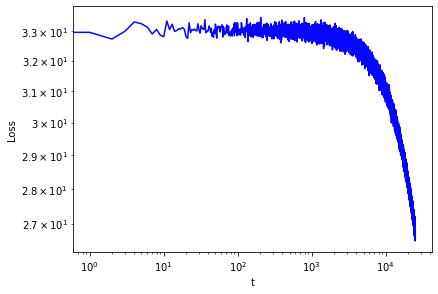

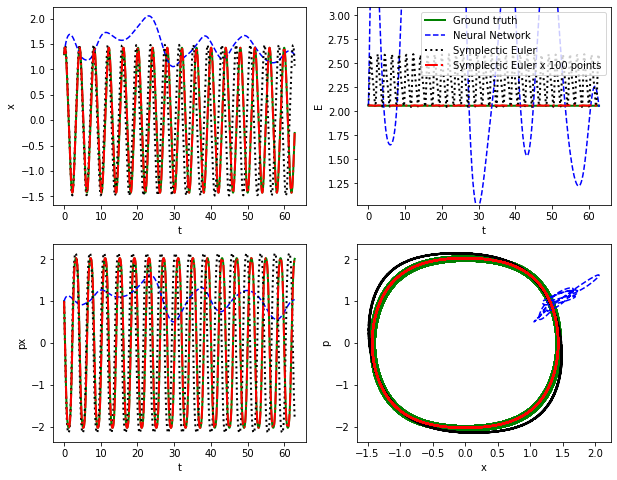

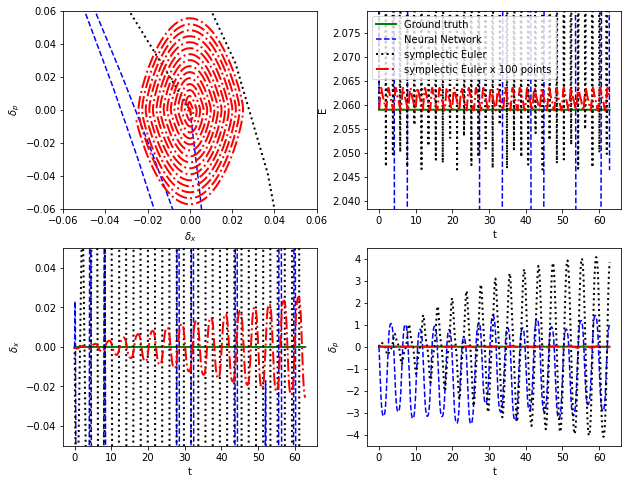

In [181]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul  2 16:15:33 2020
@author: marios
In this code a Hamiltonian Neural Network is designed and employed
to solve a system of two differential equations obtained by Hamilton's
equations for the Hamiltonian of nonlinear oscillator.
"""

import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
# import matplotlib
import matplotlib.pyplot as plt
import time
import copy
# from scipy.integrate import odeint
from os import path

from utils_NLoscillator import symEuler, NLosc_exact, NLosc_solution, energy ,saveData

dtype=torch.float


# %matplotlib inline
plt. close('all')



# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

#####################################
# Hamiltonian Neural Network (HNN) class
####################################

# Calculate the derivatice with auto-differention
def dfx(x,f):
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
#   stochastic perturbation of the evaluation points
#   force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]  
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    # t.data[0] = torch.ones(1,1)*t0
    t.requires_grad = False
    return t

# Define some functions used by the Hamiltonian network
def parametricSolutions(t, nn, X0):
    # parametric solutions
    t0, x0, px0, _ = X0[0],X0[1],X0[2],X0[3]
    N1, N2  = nn(t)
    dt =t-t0
#### THERE ARE TWO PARAMETRIC SOLUTIONS. Uncomment f=dt 
    f = (1-torch.exp(-dt)) 
    # f = dt
    x_hat  = x0  + f*N1 
    px_hat = px0 + f*N2 
    return x_hat, px_hat

def hamEqs_Loss(t,x,px,lam):
    # Define the loss function by Hamilton Eqs., write explicitely the Ham. Equations
    xd,pxd= dfx(t,x),dfx(t,px)
    fx  = xd - px; 
    fpx = pxd + x + lam*x.pow(3)
    Lx  = (fx.pow(2)).mean();     Lpx = (fpx.pow(2)).mean();
    L = Lx  + Lpx
    return L


def hamiltonian(x,px,lam):
    #returns the hamiltonian ham for Kinetic (K)  and Potential (V) Energies
    K = 0.5*px**2
    V = 0.5*x**2  + lam*x**4/4           
    ham = K + V
    return ham
    


# NETWORK ARCHITECTURE
    
# A two hidden layer NN, 1 input & two output
class odeNet_NLosc_MM(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(odeNet_NLosc_MM,self).__init__()

#####    CHOOCE THE ACTIVATION FUNCTION
        self.actF = mySin()
        # self.actF = torch.nn.Sigmoid()   

# define layers
        self.Lin_1   = torch.nn.Linear(1, D_hid)
        self.Lin_2   = torch.nn.Linear(D_hid, D_hid)
        self.Lin_out = torch.nn.Linear(D_hid, 2)

    def forward(self,t):
        # layer 1
        l = self.Lin_1(t);    h = self.actF(l)
        # layer 2
        l = self.Lin_2(h);    h = self.actF(l)

        # output layer
        r = self.Lin_out(h)
        xN  = (r[:,0]).reshape(-1,1); pxN = (r[:,1]).reshape(-1,1);
        return xN, pxN



# FUNCTION NETWORK TRAINING 
def run_odeNet_NLosc_MM(X0, tf, neurons, epochs, n_train,lr, PATH= "models/model_NL", loadWeights=False,
                     minLoss=1e-3):

    global f1,f2,f3,b1,b2,b3
    f1=[]
    f2=[]
    f3=[]
    b1=[]
    b2=[]
    b3=[]
    fc0 = odeNet_NLosc_MM(neurons)
    fc1 =  copy.deepcopy(fc0) #fc1 is a deepcopy of the network with the lowest training loss
    # optimizer
    betas = [0.999, 0.9999]    
    optimizer = optim.Adadelta(fc0.parameters(), lr=lr,rho=0.9)
    Loss_history = [];     Llim =  1 
    
    t0=X0[0];
    x0,px0,lam=X0[1],X0[2],X0[3]

    # Compute the initial energy ham0 that should remain constant    
    ham0 = hamiltonian(x0, px0, lam)
    
    grid=torch.linspace(t0, tf,  n_train).reshape(-1,1)
    
## LOADING WEIGHTS PART if PATH file exists and loadWeights=True
    if path.exists(PATH) and loadWeights==True:
        checkpoint = torch.load(PATH)
        fc0.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        tt = checkpoint['epoch']
        Ltot = checkpoint['loss']
        fc0.train(); # or model.eval
    
##  TRAINING ITERATION    
    TeP0 = time.time()
    
    for tt in range(epochs):                
# Perturbing the evaluation points & forcing t[0]=t0
        t= perturbPoints(grid,t0,tf,sig=0.03*tf)
        t.requires_grad = True
#  Network solutions 
        x,px =parametricSolutions(t,fc0,X0)

# LOSS FUNCTION
    #  Loss function defined by Hamilton Eqs. 
        Ltot = hamEqs_Loss(t,x,px,lam)            
    # Energy regularization
        ham = hamiltonian(x,px,lam)
        Ltot = Ltot + (( ham - ham0).pow(2)).mean()
    
# OPTIMIZER
        Ltot.backward(retain_graph=False); #True
        optimizer.step(); loss = Ltot.data.numpy()
        layer1 = fc0.Lin_1.state_dict()
        layer2 = fc0.Lin_2.state_dict()
        layer3 = fc0.Lin_out.state_dict()
        f1.append(np.array(layer1['weight']))
        b1.append(np.array(layer1['bias']))
        f2.append(np.array(layer2['weight']))
        b2.append(np.array(layer2['bias']))
        f3.append(np.array(layer3['weight']))
        b3.append(np.array(layer3['bias']))
        optimizer.zero_grad()


# keep the loss function history
        Loss_history.append(loss)       
    
#Keep the best model (lowest loss) by using a deep copy
        if  tt > 0.8*epochs  and Ltot < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=Ltot 


# break the training after a thresold of accuracy
        if Ltot < minLoss :
            fc1 =  copy.deepcopy(fc0)
            print('Reach minimum requested loss')
            break


    TePf = time.time()
    runTime = TePf - TeP0     
    
    
    torch.save({
    'epoch': tt,
    'model_state_dict': fc1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': Ltot,
    }, PATH)
    
    return fc1, Loss_history, runTime


# TRAINING FUNCTION
def trainModel(X0, t_max, neurons, epochs, n_train, lr,  loadWeights=False, minLoss=1e-5, showLoss=True):
    model,loss,runTime = run_odeNet_NLosc_MM(X0, t_max, neurons, epochs, n_train,lr,  loadWeights=loadWeights, minLoss=minLoss)

    np.savetxt('data/loss.txt',loss)
    
    if showLoss==True :
        print('Training time (minutes):', runTime/60)
        plt.figure()
        plt.loglog(loss,'-b',alpha=0.975);
        plt.tight_layout()
        plt.ylabel('Loss');plt.xlabel('t')
    
        plt.savefig('nonlinearOscillator_loss.png')
    

def loadModel(PATH="models/model_NL"):
    fc0 = odeNet_NLosc_MM(neurons)
    checkpoint = torch.load(PATH)
    fc0.load_state_dict(checkpoint['model_state_dict'])
    fc0.train(); # or model.eval
    return fc0
    






    

# TRAIN THE NETWORK. 
# BY DEFAULT sin() activation and f=1-exp(-t) parametrization are used. These can
# To change them go to the class for network architecture and to the parametricSolution()
#

#
### EXPERIMENT 1: SHORT TIME SOLUTION
t0, t_max, N = 0., 4.*np.pi, 200; 
dt = t_max/N; 
# Set the initial state. lam controls the nonlinearity
x0, px0,  lam =  1.3, 1., 1
X0 = [t0, x0, px0, lam]
n_train, neurons, epochs, lr = N, 10, int(25000), 9e-6

## UNCOMMENT THE FOLLOWING TO RUN THIS MODEL: Comment the next experiment
# trainModel(X0, t_max, neurons, epochs, n_train, lr,  loadWeights=False, minLoss=5e-8, showLoss=True)


#
# EXPERIMENT 2: LONG TIME SOLUTION 
#
t0, t_max, N = 0., 20.*np.pi, 500; 
dt = t_max/N; 
# Set the initial state. lam controls the nonlinearity
x0, px0,  lam =  1.3, 1., 1; 
X0 = [t0, x0, px0, lam]
n_train, neurons, epochs, lr = N, 10, int(25000), 9e-6

## COMMENT THE FOLLOWING TO RUN ONLY THE FIRST EXPERIMENT
trainModel(X0, t_max, neurons, epochs, n_train, lr,  loadWeights=False, minLoss=1e-5, showLoss=True)


##
model = loadModel()




#####################################
# TEST THE PREDICTED SOLUTIONS
#######################################3
# nTest = N ; tTest = torch.linspace(t0,t_max,nTest)

nTest = 10*N ; t_max_test = 1.0*t_max
tTest = torch.linspace(t0,t_max_test,nTest)

tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()

x,px = parametricSolutions(tTest,model,X0)




# HERE WE CALCULATE THE ell_max (maximum loss in time)
xd,pxd= dfx(tTest,x), dfx(tTest,px) # derivatives obtained by back-propagation
fx  = xd - px; 
fpx = pxd + x + x.pow(3)
ell_sq = fx.pow(2) + fpx.pow(2)
ell_max = np.max(np.sqrt( ell_sq.data.numpy() ) )
print('The maximum in time loss is ', ell_max)





# ####################
# Scipy solver
######################
t_num = np.linspace(t0, t_max_test, nTest)
E0, E_ex = NLosc_exact(nTest,x0, px0, lam)
x_num,  px_num  = NLosc_solution(nTest ,t_num, x0,  px0,  lam)
E_num = energy( x_num,  px_num, lam)

# ###################
# # Symplectic Euler
# ####################
Ns = n_train -1; 
E_s, x_s, p_s, t_s = symEuler(Ns, x0, px0, t0, t_max_test,lam)
# 100 times more time points

T0 = time.time()
Ns100 = 100*n_train ; 
E_s100, x_s100, p_s100, t_s100 = symEuler(Ns100, x0,px0,t0,t_max_test,lam)
runTimeEuler = time.time() -T0
print('Euler runtime is ',runTimeEuler/60 )



################
# Make the plots
#################

x,px = parametricSolutions(tTest,model,X0)
x=x.data.numpy(); px=px.data.numpy();
E  = energy(x, px, lam)



# Figure for trajectories: x(t), p(t), energy in time E(t), 
#          and phase space trajectory p(x)

lineW = 2 # Line thickness

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(t_num,x_num,'-g',linewidth=lineW, label='Ground truth'); 
plt.plot(t_net, x,'--b', label='Neural Network')
plt.plot(t_s,x_s,':k',linewidth=lineW, label='Symplectic Euler')
plt.plot(t_s100,x_s100,'-.r',linewidth=lineW, label='Symplectic Euler X 100 points')
# plt.axvline(x=t_max, ymin=-2, ymax=2,color='g')
plt.ylabel('x');plt.xlabel('t')
#plt.legend()

plt.subplot(2,2,2)
plt.plot(t_num,E_ex,'-g',linewidth=lineW, label='Ground truth'); 
# plt.plot(t_num,E_num,'--g',linewidth=lineW, label='Ground truth'); 
plt.plot(t_net, E,'--b', label='Neural Network')
plt.plot(t_s,E_s,':k',linewidth=lineW,label='Symplectic Euler'); 
plt.plot(t_s100,E_s100,'-.r',linewidth=lineW,label='Symplectic Euler x 100 points'); 
plt.ylabel('E');plt.xlabel('t')
plt.ylim([0.5*E0,1.5*E0])
plt.legend()

plt.subplot(2,2,3)
plt.plot(t_num,px_num,'-g',linewidth=lineW); 
plt.plot(t_net, px,'--b')
plt.plot(t_s,p_s,':k',linewidth=lineW); 
plt.plot(t_s100,p_s100,'-.r',linewidth=lineW); 
plt.ylabel('px');plt.xlabel('t')

plt.subplot(2,2,4)
plt.plot(x_num,px_num,'og',linewidth=lineW); 
plt.plot(x, px,'--b')
plt.plot(x_s,p_s,':k',linewidth=lineW); 
plt.plot(x_s100,p_s100,'-.r',linewidth=lineW); 
plt.ylabel('p');plt.xlabel('x');

plt.savefig('nonlinearOscillator_trajectories.png')



## Figure for the error in the predicted solutions: delta_x and delta_p, 
# and the energy again

# calculate the errors for the solutions obtained by network 
dx_num =x_num-x_num;       dp_num=px_num-px_num
dx = x_num - x[:,0];       dp = px_num - px[:,0]


# # calculate the errors for the solutions obtained by Euler
x_numN,  px_numN  = NLosc_solution(N,t_s, x0,  px0,  lam)
dx_s = x_numN - x_s;        dp_s = px_numN - p_s

x_num100,  px_num100  = NLosc_solution(N,t_s100, x0,  px0,  lam)
dx_s100 = x_num100 - x_s100;  dp_s100 = px_num100 - p_s100


plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(dx_num,dp_num,'-g',linewidth=lineW); 
plt.plot(dx, dp,'--b')
plt.plot(dx_s,dp_s,':k',linewidth=lineW); 
plt.plot(dx_s100,dp_s100,'-.r',linewidth=lineW); 
plt.ylabel('$\delta_p$');plt.xlabel('$\delta_x$');
plt.ylim([-6e-2,6e-2])
plt.xlim([-6e-2,6e-2])
#plt.legend()

plt.subplot(2,2,2)
plt.plot(t_num,E_ex,'-g',linewidth=lineW, label='Ground truth'); 
plt.plot(t_net, E,'--b', label='Neural Network')
plt.plot(t_s,E_s,':k',linewidth=lineW,label='symplectic Euler'); 
plt.plot(t_s100,E_s100,'-.r',linewidth=lineW,label='symplectic Euler x 100 points'); 
plt.ylabel('E');plt.xlabel('t')
plt.ylim([0.99*E0,1.01*E0])
plt.legend()

plt.subplot(2,2,3)
plt.plot(t_num,dx_num,'-g',linewidth=lineW, label='Ground truth'); 
plt.plot(t_net, dx,'--b', label='Neural Network')
plt.plot(t_s,dx_s,':k',linewidth=lineW, label='symplectic Euler')
plt.plot(t_s100,dx_s100,'-.r',linewidth=lineW, label='symplectic Euler X 100 points')
plt.ylim([-0.05, 0.05])
plt.ylabel('$\delta_x$');plt.xlabel('t')

plt.subplot(2,2,4)
plt.plot(t_num,dp_num,'-g',linewidth=lineW); 
plt.plot(t_net, dp,'--b')
plt.plot(t_s,dp_s,':k',linewidth=lineW); 
plt.plot(t_s100,dp_s100,'-.r',linewidth=lineW); 
plt.ylabel('$\delta_p$');plt.xlabel('t')



plt.savefig('nonlinearOscillator_error.png')




# saveData('data/', t_net, x, px, E)
# saveData('data/Euler100/', t_s100, x_s100, p_s100, E_s100)


# np.savetxt('data/'+"dx.txt",dx)
# np.savetxt('data/'+"dp.txt",dp)
# np.savetxt('data/Euler100/'+"dx.txt",dx_s100)
# np.savetxt('data/Euler100/'+"dp.txt",dp_s100)

In [182]:
from pprint import pprint

printable = 'long statement'
pprint(printable)


'long statement'


In [183]:
pprint(f1)

流式输出内容被截断，只能显示最后 5000 行内容。
 array([[ 0.48871714],
       [ 0.07689022],
       [-0.66821283],
       [-0.3334803 ],
       [ 0.24097048],
       [-0.82871795],
       [-0.37224212],
       [ 0.22594313],
       [ 0.2051556 ],
       [-0.40437362]], dtype=float32),
 array([[ 0.4887171 ],
       [ 0.07689055],
       [-0.668213  ],
       [-0.3334807 ],
       [ 0.2409705 ],
       [-0.82871777],
       [-0.37224224],
       [ 0.22594337],
       [ 0.20515527],
       [-0.40437365]], dtype=float32),
 array([[ 0.48871702],
       [ 0.07689088],
       [-0.6682132 ],
       [-0.3334811 ],
       [ 0.24097054],
       [-0.8287176 ],
       [-0.37224236],
       [ 0.22594361],
       [ 0.20515494],
       [-0.40437368]], dtype=float32),
 array([[ 0.48871693],
       [ 0.07689121],
       [-0.66821337],
       [-0.33348152],
       [ 0.24097055],
       [-0.82871735],
       [-0.37224248],
       [ 0.22594383],
       [ 0.20515463],
       [-0.4043737 ]], dtype=float32),
 array([[ 0.4887169 ]

In [184]:

print(np.array(f1).shape)
print(np.array(f2).shape)
print(np.array(f3).shape)
print(np.array(b1).shape)
print(np.array(b2).shape)
print(np.array(b3).shape)

f1 = np.array(f1)
f2 = np.array(f2)

f3 = np.array(f3)
b1 = np.array(b1)
b2 = np.array(b2)
b3 = np.array(b3)

(25000, 10, 1)
(25000, 10, 10)
(25000, 2, 10)
(25000, 10)
(25000, 10)
(25000, 2)


In [185]:
import scipy.io

scipy.io.savemat('W1.mat',{'W1':f1})
scipy.io.savemat('W2.mat',{'W2':f2})
scipy.io.savemat('Wout.mat',{'Wout':f3})
scipy.io.savemat('B1.mat',{'B1':b1})
scipy.io.savemat('B2.mat',{'B2':b2})
scipy.io.savemat('Bout.mat',{'Bout':b3})
